# Detecting Covid-19 Cases from Coughs Recordings

---


### Author Information

- Renato Avellar Nobre - 984405
- renato.avellarnobre@studenti.unimi.it
- Audio Pattern Recognition
- Università degli Studi di Milano

## Imports & Setups

In [70]:
%matplotlib inline

import math
import IPython
from tqdm import tqdm


import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display
from pydub import AudioSegment
from pydub.playback import play


from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 500
VAL_SPLIT = 0.7

AUDIO_LEN = 100000
N_FFT = 1024
HOP_LENGTH = 256
WINDOW = "hann"

## Datasets Exploration

> **NOTE**
>
> Both datasets in this notebook were modified to remove irrelevant data and thus improve storage usage. This notebooks is designed to work with this treated data. Therefore to run the notebook download the data in [here](https://drive.google.com/file/d/1lD00u79N3O7ELfj33GIm2Fy-oCzPoopx/view?usp=sharing) unzip it, and move the both folders (coswara and kaggle) to inside this project data/raw folder.


### COUGHVID Dataset

The COUGHVID is a dataset, which provides over 25,000 crowdsourced cough recordings representing a wide range of participant ages, genders, geographic locations, and COVID-19 statuses.

These recordings were preprocessed by lowpass filtering and downsampling to 12 kHz.

Avaiable to download [here](https://www.kaggle.com/andrewmvd/covid19-cough-audio-classification)



In [71]:
coughvid_ds = pd.read_csv("../data/raw/kaggle/metadata.csv")
coughvid_ds.head()

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,0.000000,-16.5,-71.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
coughvid_ds.columns

Index(['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude',
       'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status',
       'quality_1', 'cough_type_1', 'dyspnea_1', 'wheezing_1', 'stridor_1',
       'choking_1', 'congestion_1', 'nothing_1', 'diagnosis_1', 'severity_1',
       'quality_2', 'cough_type_2', 'dyspnea_2', 'wheezing_2', 'stridor_2',
       'choking_2', 'congestion_2', 'nothing_2', 'diagnosis_2', 'severity_2',
       'quality_3', 'cough_type_3', 'dyspnea_3', 'wheezing_3', 'stridor_3',
       'choking_3', 'congestion_3', 'nothing_3', 'diagnosis_3', 'severity_3',
       'quality_4', 'cough_type_4', 'dyspnea_4', 'wheezing_4', 'stridor_4',
       'choking_4', 'congestion_4', 'nothing_4', 'diagnosis_4', 'severity_4'],
      dtype='object')

In [73]:
coughvid_ds.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27482 entries, 0 to 27481
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   27482 non-null  object 
 1   datetime               27482 non-null  object 
 2   cough_detected         27482 non-null  float64
 3   SNR                    27482 non-null  float64
 4   latitude               16047 non-null  float64
 5   longitude              16047 non-null  float64
 6   age                    15157 non-null  float64
 7   gender                 16156 non-null  object 
 8   respiratory_condition  16156 non-null  object 
 9   fever_muscle_pain      16156 non-null  object 
 10  status                 16156 non-null  object 
 11  quality_1              819 non-null    object 
 12  cough_type_1           801 non-null    object 
 13  dyspnea_1              819 non-null    object 
 14  wheezing_1             819 non-null    object 
 15  st

In [74]:
coughvid_ds_subset = coughvid_ds[~coughvid_ds["diagnosis_1"].isna() | ~coughvid_ds["diagnosis_2"].isna() |  ~coughvid_ds["diagnosis_3"].isna() | ~coughvid_ds["diagnosis_4"].isna()]
coughvid_ds_subset = coughvid_ds_subset[["uuid", "status", "diagnosis_1", "diagnosis_2", "diagnosis_3", "diagnosis_4"]]
coughvid_ds_subset.diagnosis_1.value_counts()

coughvid_ds_subset1 = coughvid_ds_subset[coughvid_ds_subset["diagnosis_1"] == "COVID-19"]
coughvid_ds_subset2 = coughvid_ds_subset[coughvid_ds_subset["diagnosis_2"] == "COVID-19"]
coughvid_ds_subset3 = coughvid_ds_subset[coughvid_ds_subset["diagnosis_3"] == "COVID-19"]
coughvid_ds_subset4 = coughvid_ds_subset[coughvid_ds_subset["diagnosis_4"] == "COVID-19"]

coughvid_ds_healthy_subset1 = coughvid_ds_subset[coughvid_ds_subset["diagnosis_1"] == "healthy_cough"]
coughvid_ds_healthy_subset2 = coughvid_ds_subset[coughvid_ds_subset["diagnosis_2"] == "healthy_cough"]
coughvid_ds_healthy_subset3 = coughvid_ds_subset[coughvid_ds_subset["diagnosis_3"] == "healthy_cough"]
coughvid_ds_healthy_subset4 = coughvid_ds_subset[coughvid_ds_subset["diagnosis_4"] == "healthy_cough"]

c19 = pd.concat([coughvid_ds_subset1, coughvid_ds_subset2, coughvid_ds_subset3, coughvid_ds_subset4])
c19.drop_duplicates(subset=["uuid"], inplace=True)
c19 = c19[["uuid", "status"]]
c19["status"] = "covid-19"

healty = pd.concat([coughvid_ds_healthy_subset1, coughvid_ds_healthy_subset2,
                    coughvid_ds_healthy_subset3, coughvid_ds_healthy_subset4])
healty.drop_duplicates(subset=["uuid"], inplace=True)
healty = healty[["uuid", "status"]]
healty["status"] = "healthy"

new_coughvid_ds = pd.concat([c19, healty])
new_coughvid_ds.drop_duplicates(subset=["uuid"], inplace=True)


new_coughvid_ds["label"] = new_coughvid_ds["status"].apply(lambda x: 0 if x == 'healthy' else 1)
new_coughvid_ds.rename(columns={'uuid': 'id'}, inplace=True)
new_coughvid_ds = new_coughvid_ds.sample(frac=1).reset_index(drop=True)
new_coughvid_ds

,id,status,label
0,6a530462-0db4-46f5-95c9-115db1ec1cb5,healthy,0
1,f5231767-4f81-4b7a-bace-c6eae80fe56c,healthy,0
2,0512e4fa-684b-4d81-8dda-a38ffd0b67a9,healthy,0
3,22975528-762e-4bd7-9f73-a3da0b485cb4,healthy,0
4,49f7f1de-5199-4291-b906-f058a8dc74d9,healthy,0
...,...,...,...
1248,d8fc622d-69af-4433-9f5d-e885f50966f9,healthy,0
1249,34fd00ad-788a-433c-a0b8-b603b33a589c,healthy,0
1250,74048b34-b37a-46c1-bd4c-ccd169c37784,healthy,0
1251,22fe63e9-7b2a-4adf-b941-844136fc1acc,healthy,0


<AxesSubplot:>

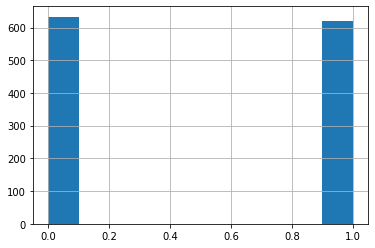

In [75]:
new_coughvid_ds["label"].hist()

In [76]:
new_coughvid_ds.to_csv("../data/features/coughvid.csv", index=False)

### Coswara Dataset

The data collection strategy focused on reaching out to the human population across the globe. There were participants across multiple genders, age groups, countries, and health status (grouped into healthy and unhealthy). 

Each participant provides 9 audio files, one for each of the sound category (breathing, coughting and vocals). All files that where not related to coughing were discarded. The coughing tracks were merged.

The audio samples are recorded at a sampling frequency of 48 kHz.

In [77]:
coswara_ds = pd.read_csv("../data/raw/coswara/metadata.csv")
coswara_ds.head()

,id,a,covid_status,record_date,ep,g,l_c,l_l,l_s,rU,...,vacc,bd,others_resp,ftg,st,ihd,asthma,others_preexist,cld,pneumonia
0,iV3Db6t1T8b7c5HQY2TwxIhjbzD3,28,healthy,2020-04-23,y,male,India,Anantapur,Andhra Pradesh,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AxuYWBN0jFVLINCBqIW5aZmGCdu1,25,healthy,2020-04-20,y,male,India,BENGALURU URBAN,Karnataka,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C5eIsssb9GSkaAgIfsHMHeR6fSh1,28,healthy,2020-04-24,y,female,United States,Pittsburgh,Pennsylvania,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YjbEAECMBIaZKyfqOvWy5DDImUb2,26,healthy,2020-04-23,y,male,India,Bangalore,Karnataka,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aGOvk4ji0cVqIzCs1jHnzlw2UEy2,32,healthy,2020-04-22,y,male,India,Nalanda,Bihar,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
coswara_ds.columns

Index(['id', 'a', 'covid_status', 'record_date', 'ep', 'g', 'l_c', 'l_l',
       'l_s', 'rU', 'smoker', 'cold', 'ht', 'diabetes', 'cough', 'ctDate',
       'ctScan', 'ctScore', 'diarrhoea', 'fever', 'loss_of_smell', 'mp',
       'testType', 'test_date', 'test_status', 'um', 'vacc', 'bd',
       'others_resp', 'ftg', 'st', 'ihd', 'asthma', 'others_preexist', 'cld',
       'pneumonia'],
      dtype='object')

In [79]:
coswara_ds.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2354 non-null   object 
 1   a                2354 non-null   int64  
 2   covid_status     2354 non-null   object 
 3   record_date      2354 non-null   object 
 4   ep               2354 non-null   object 
 5   g                2354 non-null   object 
 6   l_c              2354 non-null   object 
 7   l_l              2096 non-null   object 
 8   l_s              2354 non-null   object 
 9   rU               1683 non-null   object 
 10  smoker           710 non-null    object 
 11  cold             334 non-null    object 
 12  ht               190 non-null    object 
 13  diabetes         196 non-null    object 
 14  cough            448 non-null    object 
 15  ctDate           136 non-null    object 
 16  ctScan           590 non-null    object 
 17  ctScore       

In [80]:
new_coswara_ds = coswara_ds[["id", "covid_status"]].copy()
# Remove NaNs
new_coswara_ds.dropna(subset=['covid_status'], inplace=True)
# Remove symptomatic cases
new_coswara_ds.drop(new_coswara_ds[new_coswara_ds["covid_status"] == "recovered_full"].index, inplace=True)
new_coswara_ds.drop(new_coswara_ds[new_coswara_ds["covid_status"] == "resp_illness_not_identified"].index, inplace=True)
new_coswara_ds.drop(new_coswara_ds[new_coswara_ds["covid_status"] == "no_resp_illness_exposed"].index, inplace=True)
new_coswara_ds["label"] = new_coswara_ds["covid_status"].apply(lambda x: 0 if x == 'healthy' else 1)


<AxesSubplot:>

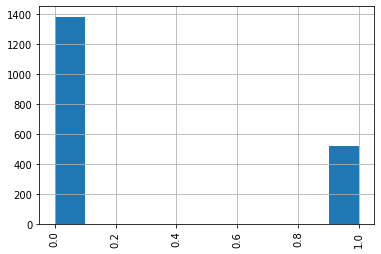

In [81]:
new_coswara_ds["label"].hist(xrot=90)

In [82]:
new_coswara_ds.to_csv("../data/features/coswara.csv", index=False)

## Audio Exploration & Feature Extraction

In [83]:
healthy_audio_file = "../data/raw/coswara/audio/iV3Db6t1T8b7c5HQY2TwxIhjbzD3.wav"
covid_audio_file = "../data/raw/coswara/audio/XbOUJCUl8GWEpQpIRMvujDE1sTE2.wav"

### Listening to Audio

##### Healthy Audio

In [84]:
sound = AudioSegment.from_file(healthy_audio_file, format="wav")
play(sound)

##### Covid-19 Audio

In [85]:
sound = AudioSegment.from_file(covid_audio_file, format="wav")
play(sound)

### Waveforms & Spectograms

In [86]:
def get_waveform(file, equal_length=False):
  file = tf.io.read_file(file)
  if equal_length:
    audio_binary, sample_rate = tf.audio.decode_wav(contents=file, desired_samples=AUDIO_LEN)
  else:
    audio_binary, sample_rate = tf.audio.decode_wav(contents=file) 
  audio_binary = tf.squeeze(audio_binary, axis=-1)
  return audio_binary.numpy(), sample_rate.numpy()

def zero_pad_wave(waveform):
  equal_length_wave = waveform
  input_len = AUDIO_LEN
  waveform = waveform[:input_len]
  zero_padding = tf.zeros([AUDIO_LEN] - tf.shape(waveform), dtype=tf.float32)
  equal_length_wave = tf.concat([waveform, zero_padding], 0).numpy()
  
  return equal_length_wave

def get_spectrogram(waveform, equal_len=False):
  
  if equal_len or waveform.shape[0] < AUDIO_LEN:
    waveform = zero_pad_wave(waveform)
    
  stft = librosa.stft(waveform,
                      n_fft=N_FFT,
                      window=WINDOW,
                      hop_length=HOP_LENGTH)

  spectogram = np.abs(stft)
  return spectogram

def get_mel_spec(waveform, sr, equal_len=False):

  if equal_len or waveform.shape[0] < AUDIO_LEN:
    waveform = zero_pad_wave(waveform)
  
  melspec = librosa.feature.melspectrogram(y=waveform,
                                           sr=sr,
                                           n_fft=N_FFT,
                                           window=WINDOW,
                                           hop_length=HOP_LENGTH)
  
  return librosa.power_to_db(melspec, ref=np.max)

def get_chroma_spec(waveform, sr):

  chromaspec = librosa.feature.chroma_stft(y=waveform,
                                        sr=sr,
                                        n_fft=N_FFT,
                                        window=WINDOW,
                                        hop_length=HOP_LENGTH)
  
  return chromaspec

#### Waveforms

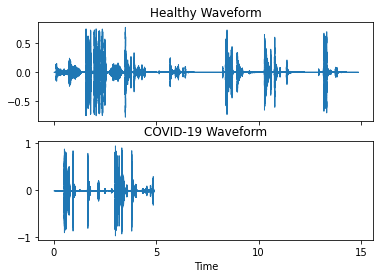

In [87]:
h_wave, h_sr = get_waveform(healthy_audio_file)
c_wave, c_sr = get_waveform(covid_audio_file)

fig, ax = plt.subplots(nrows=2, sharex=True)

librosa.display.waveshow(h_wave, sr=h_sr, ax=ax[0])
librosa.display.waveshow(c_wave, sr=c_sr, ax=ax[1])
ax[0].set(title="Healthy Waveform")
ax[0].label_outer()
ax[1].set(title="COVID-19 Waveform")
ax[1].label_outer()

#### Spectogram

In [88]:
def plot_spectogram(spectogram, audio_type):
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

    spectogram = librosa.power_to_db(spectogram, ref=np.max)

    img = librosa.display.specshow(spectogram, ax=ax[0], y_axis='linear',
                                   hop_length=HOP_LENGTH,
                                   x_axis='time')

    librosa.display.specshow(spectogram, ax=ax[1], y_axis='log',
                             hop_length=HOP_LENGTH,
                             x_axis='time')

    ax[0].set(title=f"Linear {audio_type} Spectogram")
    ax[0].label_outer()
    ax[1].set(title=f"Log {audio_type} Spectogram")
    ax[1].label_outer()
    fig.colorbar(img, ax=ax, format="%+2.f dB");

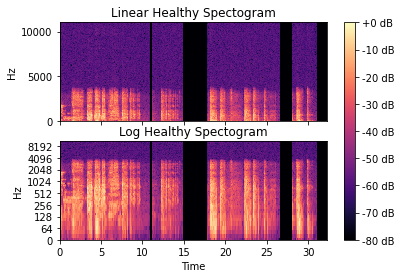

In [89]:
h_spec = get_spectrogram(h_wave)
plot_spectogram(h_spec, "Healthy")

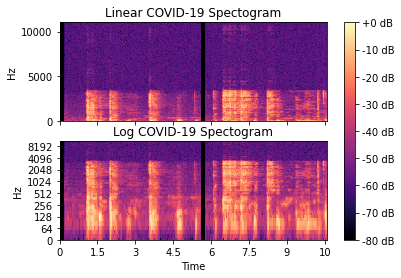

In [90]:
c_spec = get_spectrogram(c_wave)
plot_spectogram(c_spec, "COVID-19")

#### Mel Spectograms

In [91]:
def plot_mel_spectogram(spectogram, audio_type) :
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

    img = librosa.display.specshow(spectogram, ax=ax, y_axis='mel',
                                   fmax=8000, x_axis='time')

    ax.set(title=f"Mel-frequency {audio_type} Spectogram")
    ax.label_outer()

    fig.colorbar(img, ax=ax, format="%+2.f dB");

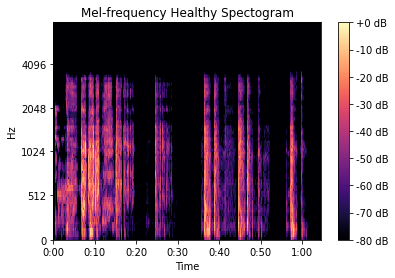

In [92]:
h_mel_spec = get_mel_spec(h_wave, h_sr, equal_len=False)
plot_mel_spectogram(h_mel_spec, "Healthy")

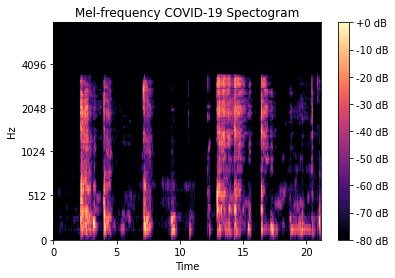

In [93]:
c_mel_spec = get_mel_spec(c_wave, c_sr, equal_len=False)
plot_mel_spectogram(c_mel_spec, "COVID-19")

#### Chroma Spectogram

In [94]:
def plot_chroma_spectogram(chroma, sr, audio_type):
    fig, ax = plt.subplots(nrows=1, sharex=True)
    
    img = librosa.display.specshow(chroma, sr=sr, y_axis='chroma', x_axis='time', ax=ax)
    ax.set(title=f"Chroma {audio_type} Spectogram")

    fig.colorbar(img, ax=[ax])

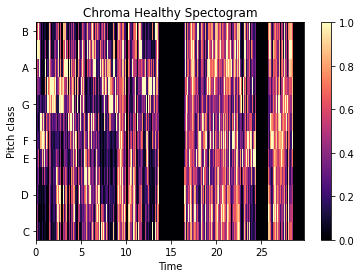

In [95]:
h_chroma = get_chroma_spec(h_wave, h_sr)
plot_chroma_spectogram(h_chroma, h_sr, "Healthy")

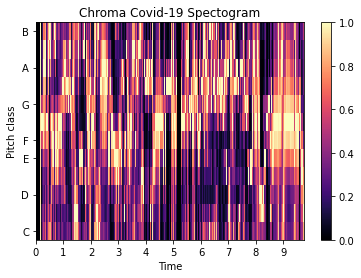

In [96]:
c_chroma = get_chroma_spec(c_wave, c_sr)
plot_chroma_spectogram(c_chroma, c_sr, "Covid-19")

### Time-Domain Features


In [97]:
def calc_rms_power(wave):
    rms = librosa.feature.rms(y=wave, 
                              frame_length=N_FFT,
                              hop_length=HOP_LENGTH)
    return rms

def calc_zero_crossing_rate(wave):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(wave, 
                                                            frame_length=N_FFT,
                                                            hop_length=HOP_LENGTH)

    return zero_crossing_rate

#### RMS Power

Compute root-mean-square (RMS) value for each frame, from the audio samples or spectogram

Computing the RMS value from audio samples is faster as it doesn’t require a STFT calculation. However, using a spectrogram will give a more accurate representation of energy over time because its frames can be windowed.

In [98]:
def plot_rms(rms, sr, cough_type):
    fig, ax = plt.subplots(nrows=1, sharex=True)
    times = librosa.times_like(rms, sr=sr)
    ax.semilogy(times, rms[0], label='RMS Energy')
    ax.legend()
    ax.set(xlabel="Time")
    ax.set(title=f"RMS Power for {cough_type}")
    ax.label_outer()

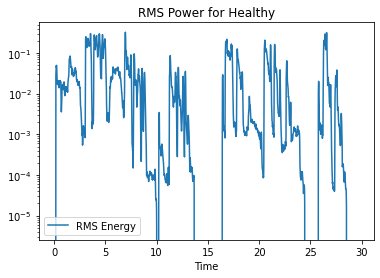

In [99]:
h_rms = calc_rms_power(h_wave)
plot_rms(h_rms, h_sr, "Healthy")

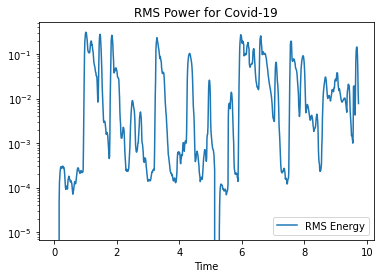

In [100]:
c_rms = calc_rms_power(c_wave)
plot_rms(c_rms, c_sr, "Covid-19")

#### Zero Crossing Rate

Compute the zero-crossing rate of an audio time series.

In [101]:
def plot_zero_crossing(zero_crossing, sr, cough_type):
    
    fig, ax = plt.subplots(nrows=1, sharex=True)

    times = librosa.times_like(zero_crossing, sr=sr)
    ax.semilogy(times, zero_crossing[0], label='Zero Crossing Rate')
    ax.set(xlabel="Time")
    ax.set(title=f"Zero Crossing Rate for {cough_type}")
    ax.legend()
    ax.label_outer()

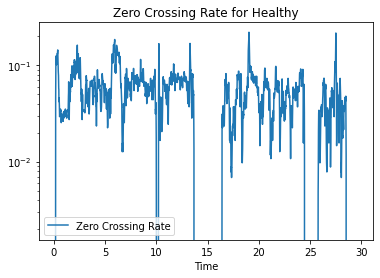

In [102]:
h_zc = calc_zero_crossing_rate(h_wave)
plot_zero_crossing(h_zc, h_sr, "Healthy")

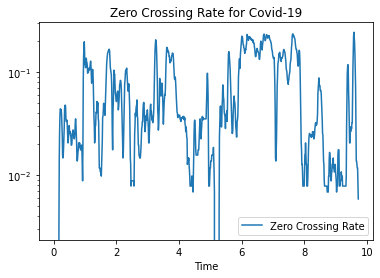

In [103]:
c_zc = calc_zero_crossing_rate(c_wave)
plot_zero_crossing(c_zc, c_sr, "Covid-19")

### Frequency-Domain Features

In [104]:
def calc_spectral_centroid(spectrogram):
    centroid = librosa.feature.spectral_centroid(S=spectrogram,
                                                 n_fft=N_FFT,
                                                 hop_length=HOP_LENGTH,
                                                 window=WINDOW)
    return centroid


def calc_spectral_bandwidth(spectrogram):
    bandwidth = librosa.feature.spectral_bandwidth(S=spectrogram,
                                                   n_fft=N_FFT,
                                                   hop_length=HOP_LENGTH,
                                                   window=WINDOW)

    return bandwidth

def calc_spectral_contrast(spectogram, sr):
    contrast = librosa.feature.spectral_contrast(S=spectogram, sr=sr)
    
    return contrast

def calc_spectral_flatness(spectogram):
    flatness = librosa.feature.spectral_flatness(S=spectogram,
                                                 n_fft=N_FFT,
                                                 hop_length=HOP_LENGTH,
                                                 window=WINDOW)

    return flatness

def calc_spectral_rolloff(spectogram, sr):
    flatness = librosa.feature.spectral_rolloff(S=spectogram, sr=sr,
                                                 n_fft=N_FFT,
                                                 hop_length=HOP_LENGTH,
                                                 window=WINDOW,
                                                 roll_percent=0.9)

    return flatness

#### Spectral Centroid

Compute the spectral centroid.

Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.

In [105]:
def plot_spectral_centroid(centroid, spec, sr, cought_type):
    times = librosa.times_like(centroid, sr=sr)
    fig, ax = plt.subplots()
    librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max),
                             sr=sr, y_axis='log', x_axis='time', ax=ax)
    ax.plot(times, centroid.T, label='Spectral centroid', color='w')
    ax.legend(loc='upper right')
    ax.set(title=f'Spectral Centroid for {cought_type}')

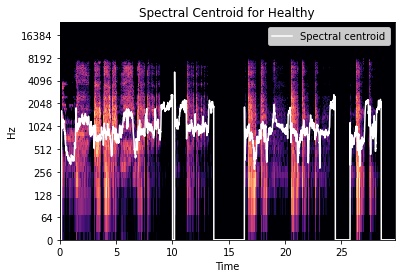

In [106]:
h_centroid = calc_spectral_centroid(h_spec)
plot_spectral_centroid(h_centroid, h_spec, h_sr, "Healthy")

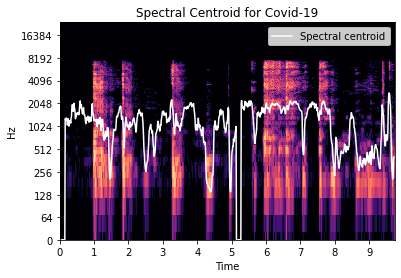

In [107]:
c_centroid = calc_spectral_centroid(c_spec)
plot_spectral_centroid(c_centroid, c_spec, c_sr, "Covid-19")

#### Spectral bandwidth

Compute p’th-order spectral bandwidth.

In [108]:
def plot_spectral_bandwidth(spec_bw, centroid, spec, sr, cough_type):

    fig, ax = plt.subplots(nrows=2, sharex=True)

    times = librosa.times_like(spec_bw, sr=sr)

    ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
    ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
    ax[0].legend()
    ax[0].label_outer()

    librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max),
                             sr=sr,
                             y_axis='log', x_axis='time', ax=ax[1])

    ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]),
                       np.minimum(centroid[0] + spec_bw[0], sr/2),
                       alpha=0.5, label='Centroid +- bandwidth')

    ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
    ax[1].legend(loc='lower right')

    ax[0].set(title=f"Spectral Centroid & Bandwidth for {cough_type}")


def plot_spectral_bandwidth_both(h_spec_bw, h_centroid, h_spec, h_sr, 
                            c_spec_bw, c_centroid, c_spec, c_sr):

    fig, ax = plt.subplots(nrows=2, sharex=True)

    h_times = librosa.times_like(h_spec_bw, sr=h_sr)
    c_times = librosa.times_like(c_spec_bw, sr=c_sr)

    librosa.display.specshow(librosa.amplitude_to_db(h_spec, ref=np.max),
                             sr=h_sr,
                             y_axis='log', x_axis='time', ax=ax[0])

    ax[0].fill_between(h_times, np.maximum(0, h_centroid[0] - h_spec_bw[0]),
                       np.minimum(h_centroid[0] + h_spec_bw[0], h_sr/2),
                       alpha=0.5, label='Centroid +- bandwidth')

    ax[0].plot(h_times, h_centroid[0], label='Spectral centroid', color='w')
    ax[0].legend(loc='lower right')

    librosa.display.specshow(librosa.amplitude_to_db(c_spec, ref=np.max),
                             sr=c_sr,
                             y_axis='log', x_axis='time', ax=ax[1])

    ax[1].fill_between(c_times, np.maximum(0, c_centroid[0] - c_spec_bw[0]),
                       np.minimum(c_centroid[0] + c_spec_bw[0], c_sr/2),
                       alpha=0.5, label='Centroid +- bandwidth')

    ax[1].plot(c_times, c_centroid[0], label='Spectral centroid', color='w')
    ax[1].legend(loc='lower right')

    ax[0].set(title=f"Spectral Centroid & Spread for Healthy Sample")
    ax[0].label_outer()
    ax[1].set(title=f"Spectral Centroid & Spread for Covid-19 Sample")
    ax[1].label_outer()

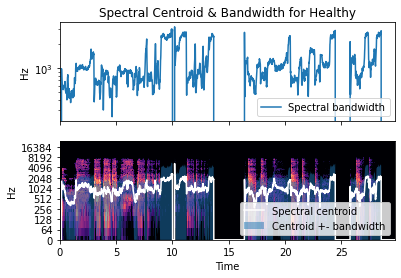

In [109]:
h_bandwidth = calc_spectral_bandwidth(h_spec)
plot_spectral_bandwidth(h_bandwidth, h_centroid, h_spec, h_sr, "Healthy")

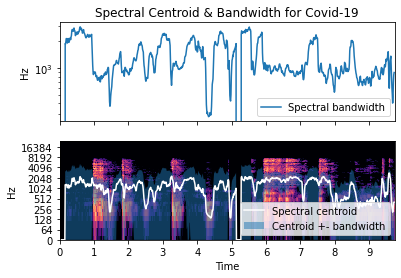

In [110]:
c_bandwidth = calc_spectral_bandwidth(c_spec)
plot_spectral_bandwidth(c_bandwidth, c_centroid, c_spec, c_sr, "Covid-19")

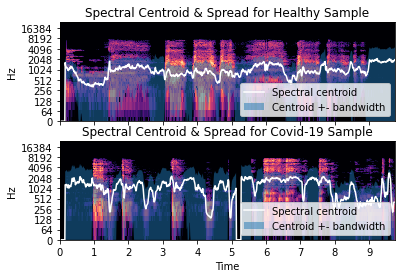

In [111]:
plot_spectral_bandwidth_both(h_bandwidth, h_centroid, h_spec, h_sr, 
                             c_bandwidth, c_centroid, c_spec, c_sr)

#### Spectral Contrast

Compute spectral contrast

Each frame of a spectrogram S is divided into sub-bands. For each sub-band, the energy contrast is estimated by comparing the mean energy in the top quantile (peak energy) to that of the bottom quantile (valley energy). High contrast values generally correspond to clear, narrow-band signals, while low contrast values correspond to broad-band noise.

In [112]:
def plot_spectral_contrast(contrast, cough_type):
    fig, ax = plt.subplots(nrows=1, sharex=True)
    img2 = librosa.display.specshow(contrast, x_axis='time', ax=ax)
    fig.colorbar(img2, ax=[ax])
    ax.set(ylabel='Frequency bands', title=f'Spectral contrast {cough_type}')

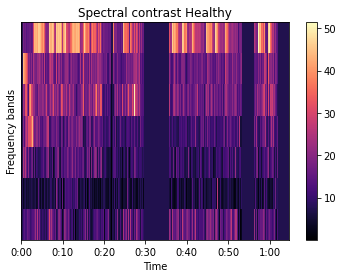

In [113]:
h_contrast = calc_spectral_contrast(h_spec, h_sr)
plot_spectral_contrast(h_contrast, "Healthy")

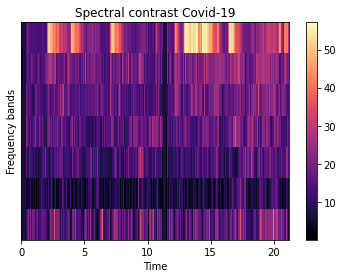

In [114]:
c_contrast = calc_spectral_contrast(c_spec, c_sr)
plot_spectral_contrast(c_contrast, "Covid-19")

#### Spectral Flatness

Compute spectral flatness

Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to being tone-like. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. It is often converted to decibel.

In [115]:
def plot_spectral_flatness(flatness, sr, cough_type):
    
    fig, ax = plt.subplots(nrows=1, sharex=True)

    times = librosa.times_like(flatness, sr=sr)
    ax.semilogy(times, flatness[0], label='Spectral Flatness')
    ax.set(xlabel="Time")
    ax.set(title=f"Spectral Flatness for {cough_type}")
    ax.legend()
    ax.label_outer()

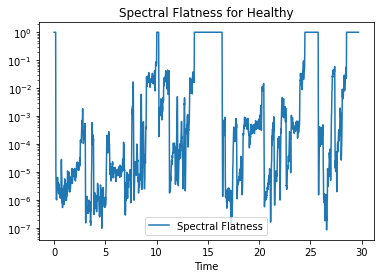

In [116]:
h_flatness = calc_spectral_flatness(h_spec)
plot_spectral_flatness(h_flatness, h_sr, "Healthy")

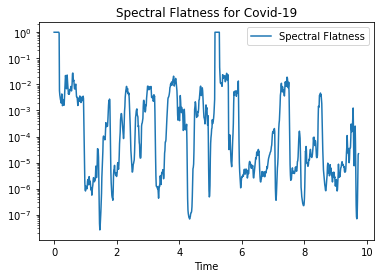

In [117]:
c_flatness = calc_spectral_flatness(c_spec)
plot_spectral_flatness(c_flatness, c_sr, "Covid-19")

#### Spectral Rolloff

Compute roll-off frequency.

The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent to a value close to 1 (or 0).

In [118]:
def plot_spectral_rolloff(spectrum, rolloff, sr, cough_type):
    fig, ax = plt.subplots()
    librosa.display.specshow(librosa.amplitude_to_db(spectrum, ref=np.max),
                             y_axis='log', x_axis='time', ax=ax, sr=sr)
    ax.plot(librosa.times_like(rolloff, sr=sr), rolloff[0], label='Roll-off frequency (0.90)')
    ax.legend(loc='lower right')
    ax.set(title=f'Spectral Rolloff for {cough_type}')

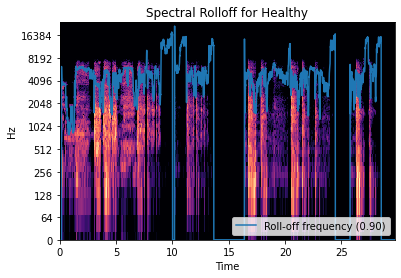

In [119]:
h_rolloff = calc_spectral_rolloff(h_spec, h_sr)
plot_spectral_rolloff(h_spec, h_rolloff, h_sr, "Healthy")

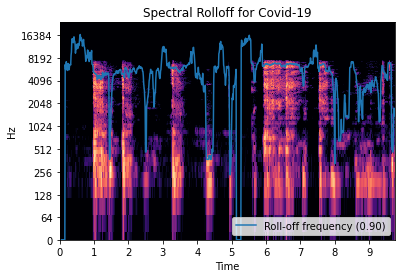

In [120]:
c_rolloff = calc_spectral_rolloff(c_spec, c_sr)
plot_spectral_rolloff(c_spec, c_rolloff, c_sr, "Covid-19")

### Mel Frequency Cepstral Coefficents (MFCCs)

The MFCC uses the MEL scale to divide the frequency band to sub-bands and then extracts the Cepstral Coefficents using Discrete Cosine Transform (DCT). MEL scale is based on the way humans distinguish between frequencies which makes it very convenient to process sounds.

A MEL scale is a unit of PITCH proposed by Stevens, Volkmann and Newmann in 1937. The MEL scale is a scale of pitches judged by listeners to be equal in distance one from another. Because of how humans perceive sound the MEL scale is a non-lenear scale and the distances between the pitches increeses with frequency.

In [121]:
def calc_mfccs(mel_spec, sr):
    mfccs = librosa.feature.mfcc(S=mel_spec,
                                 n_mfcc=13, sr=sr)
    return mfccs

def plot_mfccs(mel_spec, mfccs, cough_type):
    fig, ax = plt.subplots(nrows=2, sharex=True)
    img = librosa.display.specshow(mel_spec,
                                    x_axis='time', y_axis='mel', fmax=8000,
                                    ax=ax[0])
    fig.colorbar(img, ax=[ax[0]])
    ax[0].set(title=f"Mel spectrogram {cough_type}")
    ax[0].label_outer()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
    fig.colorbar(img, ax=[ax[1]])
    ax[1].set(title=f"13 MFCC {cough_type}")    

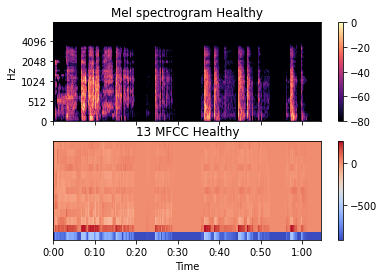

In [122]:
h_mfccs = calc_mfccs(h_mel_spec, h_sr)
plot_mfccs(h_mel_spec, h_mfccs, "Healthy")

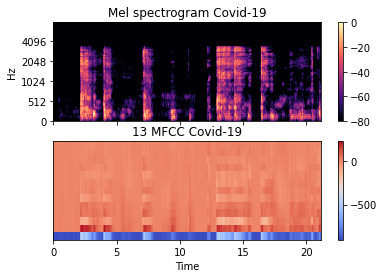

In [123]:
c_mfccs = calc_mfccs(c_mel_spec, c_sr)
plot_mfccs(c_mel_spec, c_mfccs, "Covid-19")

## Models

In [124]:
def train_val_split(dataset):
    print("[DATASET] Spliting Train and Validation")

    ds_size = len(dataset)
    val_split = math.ceil(VAL_SPLIT*ds_size)
    train_ds = dataset[:val_split]
    val_ds = dataset[val_split: ]

    return train_ds, val_ds

def calc_class_weight(labels):
    """Calculate class weights for the dnn model.
    Args:
        labels (list): Labels from the dataset.
    Returns:
        Dictionary with the weight for each class.
    """

    total = len(labels)
    pos = labels.sum()
    neg = total-pos

    weight_for_false = (1 / neg)*(total)/2.0
    weight_for_true = (1 / pos)*(total)/2.0

    class_weight = {0: weight_for_false, 1: weight_for_true}

    return class_weight

coswara_pd = pd.read_csv("../data/features/coswara.csv")
coswara_pd = coswara_pd.sample(frac=1, random_state=9).reset_index(drop=True)
coswara_audio = "../data/raw/coswara/audio/"
coswara_train, coswara_val = train_val_split(coswara_pd)


coughvid_pd = pd.read_csv("../data/features/coughvid.csv")
coughvid_audio = "../data/raw/kaggle/audio/"
coughvid_train, coughvid_val = train_val_split(coughvid_pd)

[DATASET] Spliting Train and Validation
[DATASET] Spliting Train and Validation


### SVM

#### Dataset Processing Functions

In [125]:
def calculate_features(wave, spec, mel_spec, sr):

    rms = calc_rms_power(wave)
    zcr = calc_zero_crossing_rate(wave)
    scentroid = calc_spectral_centroid(spec)
    sb = calc_spectral_bandwidth(spec)
    scontrast = calc_spectral_contrast(spec, sr)
    sf = calc_spectral_flatness(spec)
    srolloff = calc_spectral_rolloff(spec, sr)
    mffcs = calc_mfccs(mel_spec, sr)


    features = [
        np.mean(rms),
        np.std(rms),
        np.max(rms),
        np.min(rms),
        np.median(rms),

        np.mean(zcr),
        np.std(zcr),
        np.max(zcr),
        np.min(zcr),
        np.median(zcr),

        np.mean(scentroid),
        np.std(scentroid),
        np.max(scentroid),
        np.min(scentroid),
        np.median(scentroid),

        np.mean(sb),
        np.std(sb),
        np.max(sb),
        np.min(sb),
        np.median(sb),

        np.mean(sf),
        np.std(sf),
        np.max(sf),
        np.min(sf),
        np.median(sf),

        np.mean(srolloff),
        np.std(srolloff),
        np.max(srolloff),
        np.min(srolloff),
        np.median(srolloff),
        ]

    features.extend(np.mean(scontrast, axis=1).tolist())
    features.extend(np.std(scontrast, axis=1).tolist())
    features.extend(np.max(scontrast, axis=1).tolist())
    features.extend(np.min(scontrast, axis=1).tolist())
    features.extend(np.median(scontrast, axis=1).tolist())

    features.extend(np.mean(mffcs, axis=1).tolist())
    features.extend(np.std(mffcs, axis=1).tolist())
    features.extend(np.max(mffcs, axis=1).tolist())
    features.extend(np.min(mffcs, axis=1).tolist())
    features.extend(np.median(mffcs, axis=1).tolist())

    return features

def create_features_data(files, audio_path):
    dataset = []
    for file in tqdm(files):
        wave, sr = get_waveform(audio_path + file + ".wav")
        spec = get_spectrogram(wave)
        mel_spec = get_mel_spec(wave, sr)
        features = calculate_features(wave, spec, mel_spec, sr)
        dataset.append(features)
    return np.array(dataset)


def create_svm_dataset(ds, audio_path):
    print(f"[DATASET] Creating Dataset")

    files = ds["id"]
    labels = ds["label"]

    features = create_features_data(files, audio_path)

    return features, labels

#### Model Functions

In [126]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

def create_svm_model(dataset, C, gamma):
    print(f"[DATASET] Creating SVM Dataset")
    model = svm.SVC(C=C, kernel='poly', degree=3, verbose=True, gamma=gamma,
                    class_weight=calc_class_weight(dataset["label"]))
    return model

def fit_svm_model(model, train_ds):
    print(f"[DATASET] Creating SVM Model")
    features, labels = train_ds
    features = preprocessing.normalize(features, norm='l2')
    trained_model = model.fit(features, labels)

    return trained_model

def get_svm_scores(trained_model, train_ds, val_ds):
    print(f"[DATASET] Evaluating SVM Model")
    train_features, train_labels = train_ds
    val_features, val_labels = val_ds
    train_features = preprocessing.normalize(train_features, norm='l2')
    val_features = preprocessing.normalize(val_features, norm='l2')

    train_pred = trained_model.predict(train_features)
    val_pred = trained_model.predict(val_features)

    train_acc = accuracy_score(train_labels, train_pred)
    train_f1 = f1_score(train_labels, train_pred, average='weighted')
    train_recall = recall_score(train_labels, train_pred, average='weighted')
    train_precision = precision_score(train_labels, train_pred, average='weighted')
    train_cm = confusion_matrix(train_labels, train_pred)
    train_roc_auc = roc_auc_score(train_labels, train_pred, average='weighted')

    val_acc = accuracy_score(val_labels, val_pred)
    val_f1 = f1_score(val_labels, val_pred, average='weighted')
    val_recall = recall_score(val_labels, val_pred, average='weighted')
    val_precision = precision_score(val_labels, val_pred, average='weighted')
    val_cm = confusion_matrix(val_labels, val_pred)
    val_roc_auc = roc_auc_score(val_labels, val_pred, average='weighted')

    print(f"Train and Validation Accuracy: {train_acc}/{val_acc}")
    print(f"Train and Validation F1: {train_f1}/{val_f1}")
    print(f"Train and Validation Recall: {train_recall}/{val_recall}")
    print(f"Train and Validation Precision: {train_precision}/{val_precision}")
    print(f"Train and Validation CM: {train_cm}/{val_cm}")
    print(f"Train and Validation ROC-AUC: {train_roc_auc}/{val_roc_auc}")

### Visualizing Feature Space with KMeans

In [127]:
from sklearn.metrics import silhouette_score

def get_full_features_data(train_ds, val_ds):
    train_features, _ = train_ds
    val_features, _ = val_ds
    full_features = np.concatenate((train_features, val_features), axis=0)
    full_features = preprocessing.StandardScaler().fit_transform(full_features)
    return full_features

def kmeans_clustering(features):
    model = KMeans(n_clusters=2, random_state=7)
    clusters = model.fit_predict(features)

    print(f"Silhouette Score: {silhouette_score(features, clusters)}")

    return model, clusters

def pca_reduction(features):
    pca = PCA(2)
    data = pca.fit_transform(features)
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_ratio_, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(features)
    return data


def plot_kmeans_pca(reduced_data, model, clusters, plot_title):
    centers = np.array(model.cluster_centers_)
    plt.figure()
    uniq = np.unique(clusters)
    for i in uniq:
        plt.scatter(reduced_data[clusters == i , 0], reduced_data[clusters == i , 1], label = i, alpha=0.5)
    plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
    plt.xlabel('PCA 0')
    plt.ylabel('PCA 1')
    plt.title(plot_title)
    plt.legend()
    plt.show()

#### Coswara SVM

In [128]:
svm_coswara_train_ds = create_svm_dataset(coswara_train, coswara_audio)
svm_coswara_val_ds = create_svm_dataset(coswara_val, coswara_audio)

[DATASET] Creating Dataset


  5%|▌         | 72/1335 [00:22<07:51,  2.68it/s]/Users/renatonobre/.pyenv/versions/3.9.1/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
100%|██████████| 1335/1335 [07:01<00:00,  3.17it/s]


[DATASET] Creating Dataset


100%|██████████| 571/571 [03:54<00:00,  2.43it/s]


Silhouette Score: 0.6236968092661032


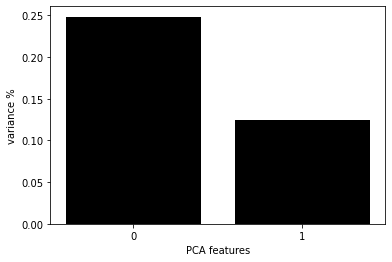

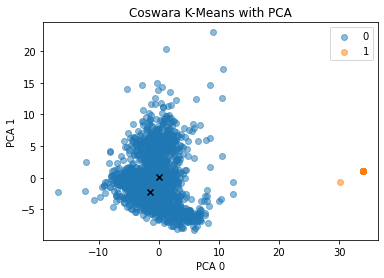

In [129]:
full_features = get_full_features_data(svm_coswara_train_ds, svm_coswara_val_ds)
reduced_features = pca_reduction(full_features)
k_means_model, clusters = kmeans_clustering(full_features)
plot_kmeans_pca(reduced_features, k_means_model, clusters, "Coswara K-Means with PCA")

In [130]:
svm_coswara_model = create_svm_model(coswara_pd, C=10000, gamma=3)
svm_coswara_model = fit_svm_model(svm_coswara_model, svm_coswara_train_ds)
get_svm_scores(svm_coswara_model, svm_coswara_train_ds, svm_coswara_val_ds)

[DATASET] Creating SVM Dataset
[DATASET] Creating SVM Model
[LibSVM][DATASET] Evaluating SVM Model
Train and Validation Accuracy: 0.8374531835205993/0.712784588441331
Train and Validation F1: 0.8432937041345804/0.7295566809051953
Train and Validation Recall: 0.8374531835205993/0.712784588441331
Train and Validation Precision: 0.865007371018211/0.7702320558885518
Train and Validation CM: [[780 173]
 [ 44 338]]/[[311 120]
 [ 44  96]]
Train and Validation ROC-AUC: 0.851642374864715/0.7036460059661915


#### Coughvid SVM

In [131]:
svm_coughvid_train_ds = create_svm_dataset(coughvid_train, coughvid_audio)
svm_coughvid_val_ds = create_svm_dataset(coughvid_val, coughvid_audio)

[DATASET] Creating Dataset


100%|██████████| 878/878 [03:01<00:00,  4.83it/s]


[DATASET] Creating Dataset


100%|██████████| 375/375 [01:14<00:00,  5.03it/s]


Silhouette Score: 0.16510606976542389


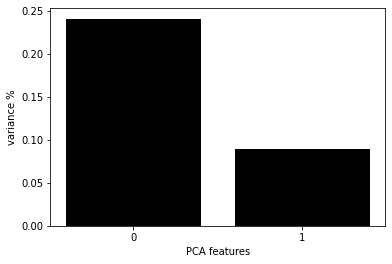

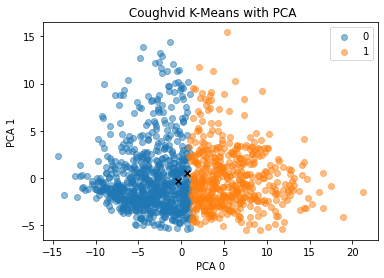

In [132]:
full_features = get_full_features_data(svm_coughvid_train_ds, svm_coughvid_val_ds)
reduced_features = pca_reduction(full_features)
k_means_model, clusters = kmeans_clustering(full_features)
plot_kmeans_pca(reduced_features, k_means_model, clusters, " Coughvid K-Means with PCA")

In [133]:
svm_coughvid_model = create_svm_model(coughvid_pd, C=100000, gamma=2)
svm_coughvid_model = fit_svm_model(svm_coughvid_model, svm_coughvid_train_ds)
get_svm_scores(svm_coughvid_model, svm_coughvid_train_ds, svm_coughvid_val_ds)

[DATASET] Creating SVM Dataset
[DATASET] Creating SVM Model
[LibSVM][DATASET] Evaluating SVM Model
Train and Validation Accuracy: 0.7892938496583144/0.616
Train and Validation F1: 0.7892733332329619/0.616092843326886
Train and Validation Recall: 0.7892938496583144/0.616
Train and Validation Precision: 0.7892712569648235/0.626393762183236
Train and Validation CM: [[334  94]
 [ 91 359]]/[[116  89]
 [ 55 115]]
Train and Validation ROC-AUC: 0.7890758047767394/0.6211621233859398


### CNN

#### Dataset Processing Functions

In [134]:
def preprocess_dataset(files, labels, audio_path):  
    mel_specs = []
    for file in tqdm(files):
        wave, sr = get_waveform(audio_path + file + ".wav")
        mel_spec = get_mel_spec(wave, sr, equal_len=True)
        mel_spec = mel_spec[..., tf.newaxis]
        mel_specs.append(mel_spec)
    output_ds = tf.data.Dataset.from_tensor_slices((np.array(mel_specs), 
                                                    labels.values))
    return output_ds

def create_train_ds(train_ds, audio_path):
    print("[DATASET] Creating Training Dataset")

    train_files = train_ds["id"]
    train_labels = train_ds["label"]

    no_batch_ds = preprocess_dataset(train_files, train_labels, audio_path)
    train_ds = no_batch_ds.batch(BATCH_SIZE)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    return train_ds, no_batch_ds

def create_val_ds(val_ds, audio_path):
    print("[DATASET] Creating Validation Dataset")

    val_files = val_ds["id"]
    val_labels = val_ds["label"]

    val_ds = preprocess_dataset(val_files, val_labels, audio_path)
    val_ds = val_ds.batch(BATCH_SIZE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)

    return val_ds

#### Model Functions

In [135]:
from tensorflow.keras import regularizers

def create_cnn_model(ds):
    print("[MODEL] Initializing Model")
    
    for spectrogram, _ in ds.take(1):
        input_shape = spectrogram.shape
        print(input_shape)

    norm_layer = layers.Normalization()
    norm_layer.adapt(data=ds.map(map_func=lambda spec, label: spec))

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.summary()

    return model

METRICS = [
    tfa.metrics.FBetaScore(num_classes=2, average="micro", threshold=0.5),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

#### Coswara CNN

In [136]:
cnn_coswara_train, cnn_coswara_shape = create_train_ds(coswara_train, coswara_audio)
cnn_coswara_val = create_val_ds(coswara_val, coswara_audio) 

[DATASET] Creating Training Dataset


  5%|▌         | 72/1335 [00:02<00:41, 30.66it/s]/Users/renatonobre/.pyenv/versions/3.9.1/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
100%|██████████| 1335/1335 [00:48<00:00, 27.51it/s]


[DATASET] Creating Validation Dataset


100%|██████████| 571/571 [00:16<00:00, 35.17it/s]


In [137]:
EARLY_STOP_CB = tf.keras.callbacks.EarlyStopping('val_fbeta_score', verbose=1, patience=20, mode='max', restore_best_weights=True)

cnn_coswara_model = create_cnn_model(cnn_coswara_shape)

cnn_coswara_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS,
)

EPOCHS = 100
cnn_coswara_history = cnn_coswara_model.fit(
    cnn_coswara_train,
    validation_data=cnn_coswara_val,
    epochs=EPOCHS,
    callbacks=EARLY_STOP_CB,
    class_weight=calc_class_weight(coswara_pd["label"])
)

[MODEL] Initializing Model
(128, 391, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatte

#### Coughvid CNN

In [138]:
cnn_coughvid_train, cnn_coughvid_shape = create_train_ds(coughvid_train, coughvid_audio)
cnn_coughvid_val = create_val_ds(coughvid_val, coughvid_audio)

[DATASET] Creating Training Dataset


100%|██████████| 878/878 [00:23<00:00, 37.83it/s]


[DATASET] Creating Validation Dataset


100%|██████████| 375/375 [00:08<00:00, 45.58it/s]


In [139]:
EARLY_STOP_CB = tf.keras.callbacks.EarlyStopping('val_fbeta_score', verbose=1, patience=20, mode='max', restore_best_weights=True)

cnn_coughvid_model = create_cnn_model(cnn_coughvid_shape)

cnn_coughvid_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS,
)

cnn_coughvid_history = cnn_coughvid_model.fit(
    cnn_coughvid_train,
    validation_data=cnn_coughvid_val,
    epochs=EPOCHS,
    callbacks=EARLY_STOP_CB,
    class_weight=calc_class_weight(coughvid_pd["label"])
)

[MODEL] Initializing Model
(128, 391, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Fl

## Results and Plots

In [140]:
def plot_cm(ds, predictions, model, title, p=0.5):
    if model == "cnn":
        labels = np.concatenate([y for _, y in ds], axis=0)
    elif model == "svm":
        labels = ds[1]
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix {title} @{p}")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

def metrics_cm(trained_model, tds, batch_size):
    metrics_results = trained_model.evaluate(tds, batch_size=batch_size, verbose=0)

    for name, value in zip(trained_model.metrics_names, metrics_results):
        print(f'{name}: {value}')

def create_roc_fig(train_info, val_info, model, title):
    """Create the ROC curve plot.
    Args:
        train_info (tuple): Train Labels and Train Prediction Values
        val_info (tuple): Val Labels and Val Prediction Values (or test)
        plot_type (str): Whether we comparing training with val or test
    """

    train_ds, train_pred = train_info
    val_ds, val_pred = val_info
    if model == "cnn":
        train_labels = np.concatenate([y for _, y in train_ds], axis=0)
        val_labels = np.concatenate([y for _, y in val_ds], axis=0)
    elif model == "svm":
        train_labels = train_ds[1]
        val_labels = val_ds[1]

    def plot_roc(name, labels, predictions, **kwargs):
        """Plot a ROC curve.
        Args:
            name (str): Type of the curve, train, val or test.
            labels ([int]): True labels
            predictions ([type]): Prediction Labels
        """
        fp, tp, _ = roc_curve(labels, predictions)

        plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
        plt.xlabel('False positives [%]')
        plt.ylabel('True positives [%]')
        plt.grid(True)
        ax = plt.gca()
        ax.set_aspect('equal')

    plt.figure()
    plot_roc("Train Baseline", train_labels, train_pred, color='b')
    plot_roc(f"Validation Baseline", val_labels,
                val_pred, color='b', linestyle='--')
    plt.legend(loc='lower right')
    plt.title(f"ROC {title}")

    plt.show()

### SVM Coswara

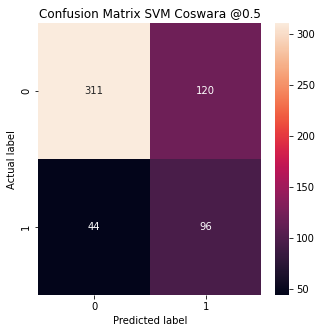

[DATASET] Evaluating SVM Model
Train and Validation Accuracy: 0.8374531835205993/0.712784588441331
Train and Validation F1: 0.8432937041345804/0.7295566809051953
Train and Validation Recall: 0.8374531835205993/0.712784588441331
Train and Validation Precision: 0.865007371018211/0.7702320558885518
Train and Validation CM: [[780 173]
 [ 44 338]]/[[311 120]
 [ 44  96]]
Train and Validation ROC-AUC: 0.851642374864715/0.7036460059661915


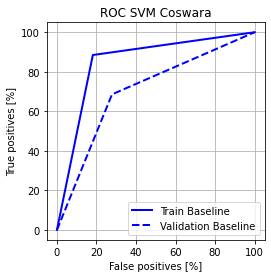

In [141]:
train_features, _ = svm_coswara_train_ds
val_features, _ = svm_coswara_val_ds
train_features = preprocessing.normalize(train_features, norm='l2')
val_features = preprocessing.normalize(val_features, norm='l2')

svm_coswara_val_pred = svm_coswara_model.predict(val_features)
svm_coswara_train_pred = svm_coswara_model.predict(train_features)

plot_cm(svm_coswara_val_ds, svm_coswara_val_pred, "svm", "SVM Coswara")
get_svm_scores(svm_coswara_model, svm_coswara_train_ds, svm_coswara_val_ds)
create_roc_fig((svm_coswara_train_ds, svm_coswara_train_pred), (svm_coswara_val_ds, svm_coswara_val_pred), "svm",  "SVM Coswara")

### SVM Coughvid

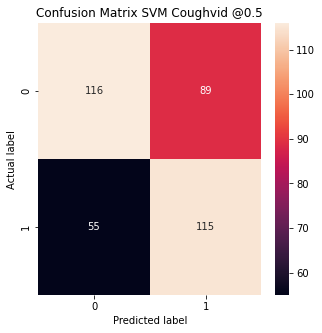

[DATASET] Evaluating SVM Model
Train and Validation Accuracy: 0.7892938496583144/0.616
Train and Validation F1: 0.7892733332329619/0.616092843326886
Train and Validation Recall: 0.7892938496583144/0.616
Train and Validation Precision: 0.7892712569648235/0.626393762183236
Train and Validation CM: [[334  94]
 [ 91 359]]/[[116  89]
 [ 55 115]]
Train and Validation ROC-AUC: 0.7890758047767394/0.6211621233859398


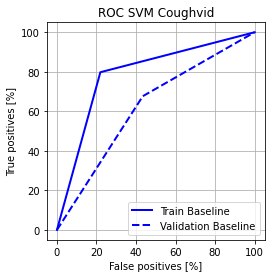

In [142]:
train_features, _ = svm_coughvid_train_ds
val_features, _ = svm_coughvid_val_ds
train_features = preprocessing.normalize(train_features, norm='l2')
val_features = preprocessing.normalize(val_features, norm='l2')

svm_coughvid_val_pred = svm_coughvid_model.predict(val_features)
svm_coughvid_train_pred = svm_coughvid_model.predict(train_features)

plot_cm(svm_coughvid_val_ds, svm_coughvid_val_pred, "svm", "SVM Coughvid")
get_svm_scores(svm_coughvid_model, svm_coughvid_train_ds, svm_coughvid_val_ds)
create_roc_fig((svm_coughvid_train_ds, svm_coughvid_train_pred), (svm_coughvid_val_ds, svm_coughvid_val_pred), "svm", "SVM Coughvid")

### CNN Coswara

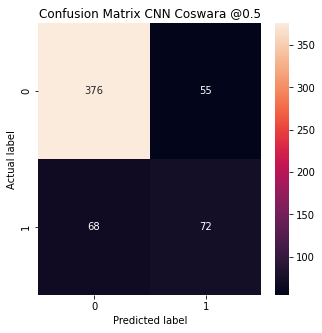

Train Metrics
loss: 0.26258155703544617
fbeta_score: 0.819407045841217
tp: 304.0
fp: 56.0
tn: 897.0
fn: 78.0
binary_accuracy: 0.8996254801750183
precision: 0.8444444537162781
recall: 0.7958115339279175
auc: 0.9670577049255371
prc: 0.9232757091522217


Validation Metrics
loss: 0.5240813493728638
fbeta_score: 0.5393258333206177
tp: 72.0
fp: 55.0
tn: 376.0
fn: 68.0
binary_accuracy: 0.7845884561538696
precision: 0.5669291615486145
recall: 0.5142857432365417
auc: 0.7429980039596558
prc: 0.539657473564148


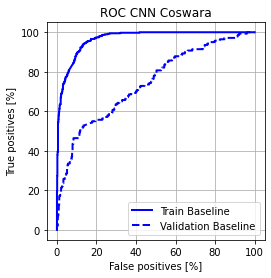

In [143]:
cnn_coswara_val_pred = cnn_coswara_model.predict(cnn_coswara_val, batch_size=BATCH_SIZE)
cnn_coswara_train_pred = cnn_coswara_model.predict(cnn_coswara_train, batch_size=BATCH_SIZE)

plot_cm(cnn_coswara_val, cnn_coswara_val_pred, "cnn", "CNN Coswara")
print("Train Metrics")
metrics_cm(cnn_coswara_model, cnn_coswara_train, BATCH_SIZE)
print("\n\nValidation Metrics")
metrics_cm(cnn_coswara_model, cnn_coswara_val, BATCH_SIZE)
create_roc_fig((cnn_coswara_train, cnn_coswara_train_pred), (cnn_coswara_val, cnn_coswara_val_pred), "cnn", "CNN Coswara")

### CNN COUGHVID

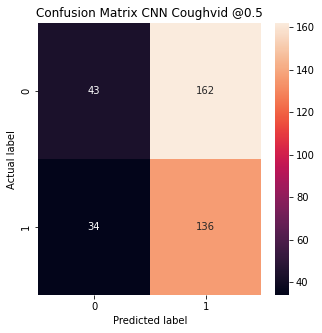

loss: 0.678346574306488
fbeta_score: 0.6534140110015869
tp: 378.0
fp: 329.0
tn: 99.0
fn: 72.0
binary_accuracy: 0.5432801842689514
precision: 0.5346534848213196
recall: 0.8399999737739563
auc: 0.6118977069854736
prc: 0.6428128480911255


Validation Metrics
loss: 0.7206601500511169
fbeta_score: 0.5811966061592102
tp: 136.0
fp: 162.0
tn: 43.0
fn: 34.0
binary_accuracy: 0.47733333706855774
precision: 0.4563758373260498
recall: 0.800000011920929
auc: 0.5261262655258179
prc: 0.47428691387176514


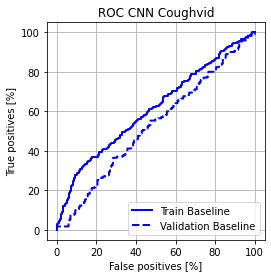

In [144]:
cnn_coughvid_val_pred = cnn_coughvid_model.predict(cnn_coughvid_val, batch_size=BATCH_SIZE)
cnn_coughvid_train_pred = cnn_coughvid_model.predict(cnn_coughvid_train, batch_size=BATCH_SIZE)

plot_cm(cnn_coughvid_val, cnn_coughvid_val_pred, "cnn", "CNN Coughvid")
metrics_cm(cnn_coughvid_model, cnn_coughvid_train, BATCH_SIZE)
print("\n\nValidation Metrics")
metrics_cm(cnn_coughvid_model, cnn_coughvid_val, BATCH_SIZE)
create_roc_fig((cnn_coughvid_train, cnn_coughvid_train_pred), (cnn_coughvid_val, cnn_coughvid_val_pred), "cnn", "CNN Coughvid")